In [1]:
from skimage.data import brain
from skimage.transform import resize, radon, iradon
import numpy as np
import torch, torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
#Setup 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nxd = 182
theta = np.linspace(0., 180., max(nxd, 180), endpoint=False)

In [3]:
#Reading in CT scan Data 
import nibabel as nib

img = nib.load("LondonPride_000101_dynPET.img")
pet_data = img.get_fdata() 

print(pet_data.shape)

# Get full Z range and calculate start and end
total_slices = pet_data.shape[2]
center = total_slices // 2
half_window = 15
z_start = center - half_window
z_end = center + half_window

# Just to be safe:
z_start = max(0, z_start)
z_end = min(total_slices, z_end)

print(z_start, z_end)

# Get full t range and calculate start and end
total_slices = pet_data.shape[3]
center = total_slices // 2
half_window = 3
t_start = center - half_window
t_end = center + half_window

# Just to be safe:
t_start = max(0, t_start)
t_end = min(total_slices, t_end)

print(t_start, t_end)

(182, 218, 182, 23)
76 106
8 14


In [4]:
#Function to add Poisson noise to the sinogram

def add_poisson(sino, max_counts):

    max_val = sino.max() #max sinogram value

    if max_val <= 0 or not np.isfinite(max_val):
        return np.zeros_like(sino)
    
    #Normalise and scale sinogram so that the max value becomes max_counts
    scale = max_counts / max_val
    scaled_sino = sino * scale

    scaled_sino = np.clip(scaled_sino, 0, 1e6)

    #Generate Posson distributed random values with mean = scaled_sino
    noisy = np.random.poisson(scaled_sino)

    return noisy / scale

def mlem_reco(sino, azi_angles, num_its: int):
    #Define reconstructed image
    image_size = sino.shape[0]   #define image reco size based on sinogram height
    mlem_rec = np.ones((image_size, image_size))

    #Compute sensitivity image (A^T 1)
    sens_image = iradon(
        np.ones_like(sino),
        azi_angles,
        circle=True,
        filter_name=None,
        output_size=image_size
    )

    for iter in range(num_its):  
        fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)
        #print(fp.shape)

        ratio = sino / (fp + 0.000001) #ratio sinogram, tells you how off the estimate was
        correction = iradon(ratio, azi_angles, circle=True , filter_name=None, output_size=image_size) / (sens_image + 0.000001) # No filter because we are just getting the transpose A^T

        mlem_rec = mlem_rec * correction

    return mlem_rec

In [5]:
import random

images = []
sinograms = []

def crop_to_square(img):
    h, w = img.shape
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    return img[top:top + min_dim, left:left + min_dim]

max_counts = [None, 1e2, 1e3, 1e4]

for t in range(t_start, t_end): #Time framse
    for z in range(z_start, z_end): #Central 100 slices

        slice_img = pet_data[:, :, z, t]

        image_cropped = crop_to_square(slice_img)
        image_resized = resize(image_cropped, (nxd, nxd), anti_aliasing=True)
        images.append(image_resized.astype(np.float32))
        
        # Generate sinogram
        sino_clean = radon(image_cropped, theta=theta, circle=True)

        noise_choice = random.choice(max_counts)

        if noise_choice is None:
            sinograms.append(sino_clean)
        else:
            sino_noisy = add_poisson(sino_clean, max_counts=noise_choice)
            sinograms.append(sino_noisy)
        


    #print("Image shape:", images[0].shape)
    #print("Sinogram shape:", sinograms[0].shape)    

# Convert to NumPy arrays
images = np.array(images)
sinograms = np.array(sinograms)


# Split into train, val, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(sinograms, images, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Train: 144, Val: 32, Test: 4


In [7]:
#Class to get the datasets (sinograms/images) in a format that pytorch can use
class MLEMDataset(Dataset):
    def __init__(self, sinograms, images):
        self.sinograms = sinograms
        self.images = images

    def __len__(self):
        return len(self.sinograms)
    
    #Enables use to get one item at a time
    def __getitem__(self, idx):
        sino = torch.from_numpy(self.sinograms[idx]).float()
        img = torch.from_numpy(self.images[idx]).float()
        return sino, img
    
train_dataset = MLEMDataset(X_train, y_train)
val_dataset = MLEMDataset(X_val, y_val)
test_dataset = MLEMDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [8]:
#Functions

#Convert numpy to torch
def np_to_torch(x):
    return torch.from_numpy(x).float().to(device)

#Convert torch to numpy
def torch_to_np(x):
    return x.detach().cpu().numpy()

#MLEM forward and backward projections
def forward_proj(image_np):
    return radon(image_np, theta=theta, circle=True)

def back_proj(sino_np):
    return iradon(sino_np, theta=theta, circle=True, filter_name = None)

#Torch versions
def fp_torch(image):
    return np_to_torch(forward_proj(torch_to_np(image)))

def bp_torch(sino):
    return np_to_torch(back_proj(torch_to_np(sino)))

In [9]:
#CNN Architecture 

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding=3), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=3), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=3), nn.PReLU(),
            nn.Conv2d(8, 1, 7, padding=3), nn.PReLU()
        )
    def forward(self, x):
        return self.net(x)
    
cnn = CNN().to(device)

In [10]:
#MLEM and CNN model

class MLEM_CNN_Net(nn.Module):
    def __init__(self, cnn, num_its):
        super().__init__()
        self.cnn = cnn
        self.default_num_its = num_its

    def forward(self, sino, num_its=None):
        sino = sino.to(device)
        sens = bp_torch(torch.ones_like(sino))
        recon = torch.ones_like(sino)

        # Use given num_its, fallback to default
        iters = num_its if num_its is not None else self.default_num_its

        for _ in range(iters):
            fp = fp_torch(recon)
            ratio = sino / (fp + 1e-9)
            correction = bp_torch(ratio) / (sens + 1e-9)
            recon = recon * correction

            #CNN Enhancement
            recon = recon.unsqueeze(0).unsqueeze(0) #[1, 1, H, W]
            recon = recon + self.cnn(recon)
            recon = recon.squeeze() #[H, W]
            recon = torch.abs(recon)

        return recon


In [11]:
#Instantiate the model
num_its = 5
cnn_mlem = MLEM_CNN_Net(cnn, num_its).to(device)

In [12]:
#Training the CNN
from tqdm import tqdm

loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(cnn_mlem.parameters(), lr = 1e-3)

train_loss = []
val_loss = []
epochs = 20

for ep in range(epochs):
    cnn_mlem.train()
    running_train_loss = 0 

    for sino, target in tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", leave=False):

        sino = sino.squeeze(0).to(device)
        target = target.squeeze(0).to(device)

        output = cnn_mlem(sino)
        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        running_train_loss += loss.item()
    
    train_loss.append(running_train_loss / len(train_loader))

    #Validation
    cnn_mlem.eval()
    running_val_loss = 0
    with torch.no_grad():
        for val_sino, val_target in tqdm(val_loader, desc="Validation", leave=False):
            val_sino = val_sino.squeeze(0).to(device)
            val_target = val_target.squeeze(0).to(device)
            val_output = cnn_mlem(val_sino)
            val_loss_val = loss_fn(val_output, val_target)
            running_val_loss += val_loss_val.item()

    val_loss.append(running_val_loss / len(val_loader))
    print(f"Epoch {ep+1} | Train Loss: {train_loss[-1]:.6f} | Val Loss: {val_loss[-1]:.6f}")

Epoch 1/20:   0%|          | 0/144 [00:00<?, ?it/s]/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Epoch 1 | Train Loss: 10.715446 | Val Loss: 7.048189


Epoch 2 | Train Loss: 6.426898 | Val Loss: 5.481294


Epoch 3 | Train Loss: 5.768067 | Val Loss: 6.345725


Epoch 4 | Train Loss: 5.426816 | Val Loss: 4.645287


Epoch 5 | Train Loss: 5.124437 | Val Loss: 4.943804


Epoch 6 | Train Loss: 5.144718 | Val Loss: 4.416245


Epoch 7 | Train Loss: 5.125416 | Val Loss: 4.935035


Epoch 8 | Train Loss: 5.400055 | Val Loss: 4.880329


Epoch 9 | Train Loss: 4.927153 | Val Loss: 4.397207


Epoch 10 | Train Loss: 4.685418 | Val Loss: 4.143915


Epoch 11 | Train Loss: 4.737743 | Val Loss: 4.351955


Epoch 12 | Train Loss: 4.794228 | Val Loss: 4.064997


Epoch 13 | Train Loss: 4.647825 | Val Loss: 4.562617


Epoch 14 | Train Loss: 4.739333 | Val Loss: 4.438318


Epoch 15 | Train Loss: 4.568195 | Val Loss: 4.641780


Epoch 16 | Train Loss: 4.700897 | Val Loss: 3.931071


Epoch 17 | Train Loss: 4.663595 | Val Loss: 4.549791


Epoch 18 | Train Loss: 4.736645 | Val Loss: 3.927658


Epoch 19 | Train Loss: 4.458708 | Val Loss: 4.124447


Epoch 20 | Train Loss: 4.637934 | Val Loss: 4.075981


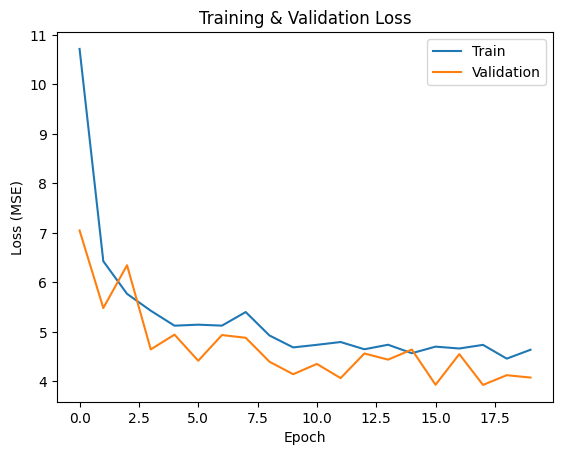

In [13]:
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

In [ ]:
'''# Comparison plot
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

cnn_mlem.eval()

mlem_mses = []
mlem_ssims = []
cnn_mses = []
cnn_ssims = []

examples = []

with torch.no_grad():
    for idx, (sino, target) in enumerate(test_loader):
        sino_np = sino.squeeze(0).numpy()
        target_np = target.squeeze(0).numpy()

        # ----- MLEM only -----
        reco_mlem = mlem_reco(sino_np, theta, num_its)
        mse_mlem = mean_squared_error(target_np, reco_mlem)
        ssim_mlem = ssim(target_np, reco_mlem, data_range=target_np.max() - target_np.min())

        mlem_mses.append(mse_mlem)
        mlem_ssims.append(ssim_mlem)

        # ----- MLEM + CNN -----
        sino = sino.squeeze(0).to(device)
        reco_cnn = cnn_mlem(sino).cpu().numpy()
        mse_cnn = mean_squared_error(target_np, reco_cnn)
        ssim_cnn = ssim(target_np, reco_cnn, data_range=target_np.max() - target_np.min())

        cnn_mses.append(mse_cnn)
        cnn_ssims.append(ssim_cnn)

        # Save examples
        if idx < 2:
            examples.append((target_np, reco_mlem, reco_cnn, mse_mlem, ssim_mlem, mse_cnn, ssim_cnn))

# ---- Print Averages ----
print("\nAverage Metrics on Test Set")
print(f"MLEM Only   - MSE: {np.mean(mlem_mses):.4f}, SSIM: {np.mean(mlem_ssims):.4f}")
print(f"MLEM + CNN  - MSE: {np.mean(cnn_mses):.4f}, SSIM: {np.mean(cnn_ssims):.4f}")'''


Average Metrics on Test Set
MLEM Only   - MSE: 19.4718, SSIM: 0.4767
MLEM + CNN  - MSE: 4.8579, SSIM: 0.8352


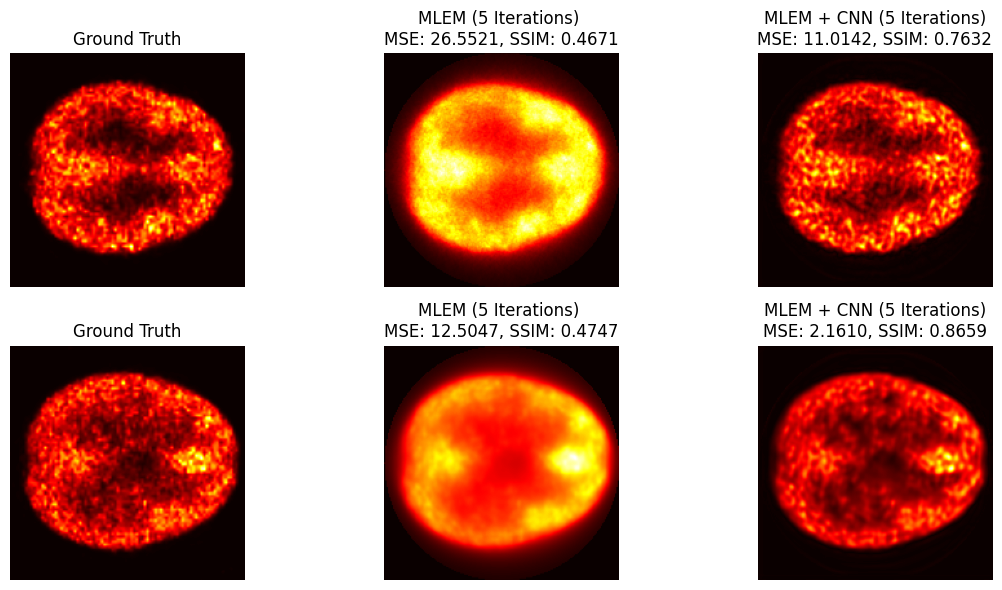

In [ ]:
'''fig, axs = plt.subplots(len(examples), 3, figsize=(12, 3 * len(examples)))

for i, (true_img, mlem_img, cnn_img, mse_val_mlem, ssim_val_mlem, mse_cnn, ssim_cnn) in enumerate(examples):
    axs[i, 0].imshow(true_img, cmap='hot')
    axs[i, 0].set_title("Ground Truth")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mlem_img, cmap='hot')
    axs[i, 1].set_title(f"MLEM ({num_its} Iterations) \nMSE: {mse_val_mlem:.4f}, SSIM: {ssim_val_mlem:.4f}")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(cnn_img, cmap='hot')
    axs[i, 2].set_title(f"MLEM + CNN ({num_its} Iterations)\nMSE: {mse_cnn:.4f}, SSIM: {ssim_cnn:.4f}")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()'''

In [ ]:
#Getting the MLEM reconstructed images
mlem_train, mlem_val, mlem_test = [], [], []

for sino, _ in train_dataset:
    sino = torch_to_np(sino)
    mlem_train.append(mlem_reco(sino, theta, 5))

for sino, _ in val_dataset:
    sino = torch_to_np(sino)
    mlem_val.append(mlem_reco(sino, theta, 5))

for sino, _ in test_dataset:
    sino = torch_to_np(sino)
    mlem_test.append(mlem_reco(sino, theta, 5))

mlem_train = np.array(mlem_train)
mlem_val = np.array(mlem_val)
mlem_test = np.array(mlem_test)

/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


In [25]:
train_dataset = MLEMDataset(mlem_train, y_train)
val_dataset = MLEMDataset(mlem_val, y_val)
test_dataset = MLEMDataset(mlem_test, y_test)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

mlem_train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
mlem_val_loader = DataLoader(val_dataset, batch_size=1)
mlem_test_loader = DataLoader(test_dataset, batch_size=1)

Train: 144, Val: 32, Test: 4


In [26]:
class CNN_denoise(nn.Module):
    def __init__(self):
        super(CNN_denoise, self).__init__()
        self.CNN_denoise = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 1, 7, padding=(3,3))
        )

    def forward(self, x):
        return x + self.CNN_denoise(x)

In [27]:
from tqdm import tqdm

model = CNN_denoise().to(device)
loss_function = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.003)

train_loss_history, val_loss_history = [], []
epochs = 30

for epoch in range(epochs):

    model.train()
    running_train_loss = 0

    for mlem_im, target in tqdm(mlem_train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):

        # Expect [B, 1, H, W]; add channel dim if missing
        if mlem_im.ndim == 3:  # [B, H, W]
            mlem_im = mlem_im.unsqueeze(1)
        if target.ndim == 3:
            target = target.unsqueeze(1)

        mlem_im = mlem_im.to(device).float()
        target  = target.to(device).float()

        output = model(mlem_im)
        loss = loss_function(output, target)
        loss.backward()
        optim.step()
        optim.zero_grad()

        running_train_loss += loss.item()

    train_loss_history.append(running_train_loss / len(mlem_train_loader))

    #Validation

    model.eval()
    running_val_loss = 0

    with torch.no_grad():

            for val_mlem_im, val_target in tqdm(mlem_val_loader, desc="Validation", leave=False):
                if val_mlem_im.ndim == 3:
                    val_mlem_im = val_mlem_im.unsqueeze(1)
                if val_target.ndim == 3:
                    val_target = val_target.unsqueeze(1)

                val_mlem_im = val_mlem_im.to(device).float()
                val_target  = val_target.to(device).float()

                val_output = model(val_mlem_im)
                val_loss = loss_function(val_output, val_target)
                running_val_loss += val_loss.item()

    val_loss_history.append(running_val_loss / len(mlem_val_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_loss_history[-1]:.6f} | Val Loss: {val_loss_history[-1]:.6f}")

Epoch 1 | Train Loss: 13.573069 | Val Loss: 8.192410


Epoch 2 | Train Loss: 6.046037 | Val Loss: 4.941309


Epoch 3 | Train Loss: 5.233074 | Val Loss: 4.621005


Epoch 4 | Train Loss: 4.933541 | Val Loss: 5.879670


Epoch 5 | Train Loss: 4.970525 | Val Loss: 4.310756


Epoch 6 | Train Loss: 4.754809 | Val Loss: 4.186930


Epoch 7 | Train Loss: 4.666795 | Val Loss: 4.157813


Epoch 8 | Train Loss: 4.525761 | Val Loss: 4.390947


Epoch 9 | Train Loss: 4.739112 | Val Loss: 4.614587


Epoch 10 | Train Loss: 4.498952 | Val Loss: 4.068520


Epoch 11 | Train Loss: 4.642123 | Val Loss: 3.867489


Epoch 12 | Train Loss: 4.365268 | Val Loss: 3.872540


Epoch 13 | Train Loss: 4.440591 | Val Loss: 4.407657


Epoch 14 | Train Loss: 4.360688 | Val Loss: 3.732275


Epoch 15 | Train Loss: 4.133937 | Val Loss: 3.528425


Epoch 16 | Train Loss: 4.256049 | Val Loss: 3.932464


Epoch 17 | Train Loss: 4.227729 | Val Loss: 4.830275


Epoch 18 | Train Loss: 4.512665 | Val Loss: 5.144916


Epoch 19 | Train Loss: 4.366128 | Val Loss: 3.835296


Epoch 20 | Train Loss: 4.431766 | Val Loss: 3.794878


Epoch 21 | Train Loss: 4.187065 | Val Loss: 3.873851


Epoch 22 | Train Loss: 4.270614 | Val Loss: 4.410902


Epoch 23 | Train Loss: 4.432849 | Val Loss: 3.855970


Epoch 24 | Train Loss: 4.204442 | Val Loss: 4.177574


Epoch 25 | Train Loss: 4.580080 | Val Loss: 3.879976


Epoch 26 | Train Loss: 4.551421 | Val Loss: 4.375689


Epoch 27 | Train Loss: 4.196493 | Val Loss: 3.793288


Epoch 28 | Train Loss: 3.961695 | Val Loss: 3.615516


Epoch 29 | Train Loss: 4.186926 | Val Loss: 3.518128


Epoch 30 | Train Loss: 4.014318 | Val Loss: 3.778089


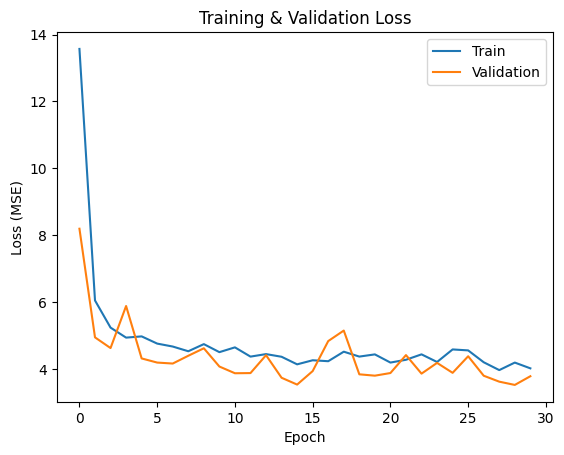

In [28]:
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

In [32]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Choose one test image for evaluation
test_idx = 0
sinogram_clean_np, true_image_np = test_dataset[test_idx]
sinogram_clean_np = radon(true_image_np, theta=theta, circle=True)
true_image_np = true_image_np.numpy()

# Noise levels
max_counts = [1e2, 3e2, 5e2, 1e3, 5e3, 1e4]
relative_noise = [np.sqrt(c) / c for c in max_counts]
mse_scores_cnn = []
ssim_scores_cnn = []
mse_scores_mlem = []
ssim_scores_mlem = []
mse_denoise = []
ssim_denoise = []

cnn_mlem.eval()
model.eval()

with torch.no_grad():
    for counts in max_counts:
        noisy_sino = add_poisson(sinogram_clean_np, max_counts=counts)
        
        # --- MLEM ---
        recon_mlem = mlem_reco(noisy_sino, theta, num_its)
        mse_mlem = mean_squared_error(true_image_np, recon_mlem)
        ssim_mlem = ssim(true_image_np, recon_mlem, data_range=true_image_np.max() - true_image_np.min())
        mse_scores_mlem.append(mse_mlem)
        ssim_scores_mlem.append(ssim_mlem)

        # --- MLEM + CNN (Denoise) --- 
        inp = torch.from_numpy(recon_mlem).float().unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
        out = model(inp)                                    # [1,1,H,W]
        mlem_cnn = out.squeeze(0).squeeze(0).cpu().numpy()  # [H, W]

        mse_denoise_val = mean_squared_error(true_image_np, mlem_cnn)
        ssim_val_denoise = ssim(true_image_np, mlem_cnn, data_range=true_image_np.max() - true_image_np.min())
        mse_denoise.append(mse_denoise_val)
        ssim_denoise.append(ssim_val_denoise)

        # --- MLEM + CNN ---
        noisy_sino_torch = np_to_torch(noisy_sino)
        recon_cnn = cnn_mlem(noisy_sino_torch).cpu().numpy()
        mse = mean_squared_error(true_image_np, recon_cnn)
        ssim_val = ssim(true_image_np, recon_cnn, data_range=true_image_np.max() - true_image_np.min())
        mse_scores_cnn.append(mse)
        ssim_scores_cnn.append(ssim_val)


/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


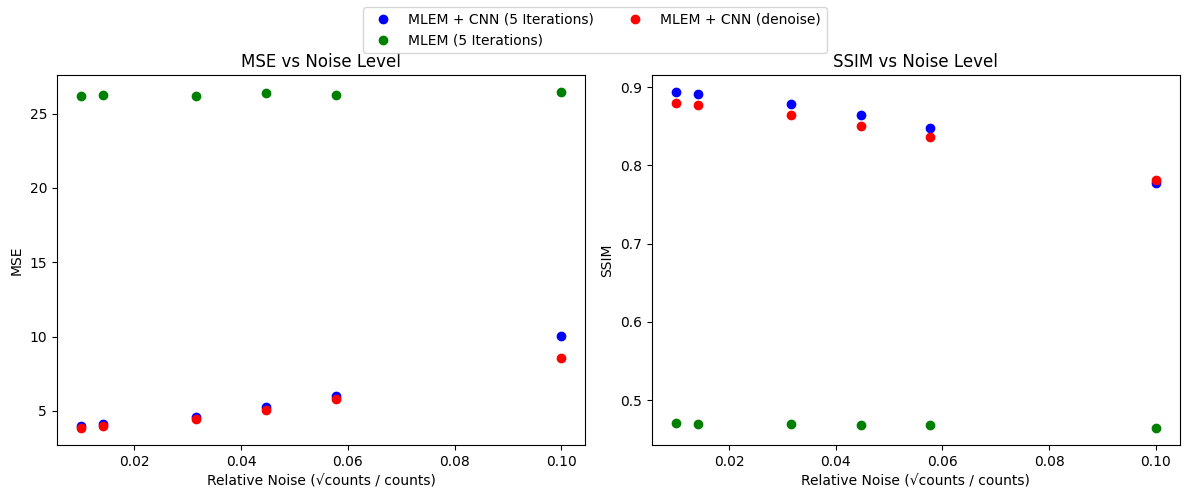

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # <- use fig and axes

# MSE plot
axes[0].plot(relative_noise, mse_scores_cnn, 'bo', label=f'MLEM + CNN ({num_its} Iterations)')
axes[0].plot(relative_noise, mse_scores_mlem, 'go', label=f'MLEM ({num_its} Iterations)')
axes[0].plot(relative_noise, mse_denoise, 'ro', label=f'MLEM + CNN (denoise)')
axes[0].set_xlabel('Relative Noise (√counts / counts)')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE vs Noise Level')

# SSIM plot
axes[1].plot(relative_noise, ssim_scores_cnn, 'bo', label=f'MLEM + CNN ({num_its} Iterations)')
axes[1].plot(relative_noise, ssim_scores_mlem, 'go', label=f'MLEM ({num_its} Iterations)')
axes[1].plot(relative_noise, ssim_denoise, 'ro', label=f'MLEM + CNN (denoise)')
axes[1].set_xlabel('Relative Noise (√counts / counts)')
axes[1].set_ylabel('SSIM')
axes[1].set_title('SSIM vs Noise Level')


# Unified legend above both plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave room for the legend
plt.show()



In [ ]:
# Choose one test image for evaluation
test_idx = 3
sinogram_clean_np, true_image_np = test_dataset[test_idx]
sinogram_clean_np = sinogram_clean_np.numpy()
true_image_np = true_image_np.numpy()
    
# --- MLEM ---
recon_mlem_it = mlem_reco(sinogram_clean_np, theta, 5)
mse_mlem_it = mean_squared_error(true_image_np, recon_mlem_it)
ssim_mlem_it = ssim(true_image_np, recon_mlem_it, data_range=true_image_np.max() - true_image_np.min())
print(f"The MSE for the MLEM algorithm is {mse_mlem_it}")
print(f"The SSIM for the MLEM algorithm is {ssim_mlem_it}")

# --- MLEM + CNN ---
recon_cnn_it = cnn_mlem(torch.tensor(sinogram_clean_np).to(device), num_its=5).detach().cpu().numpy()
mse_it = mean_squared_error(true_image_np, recon_cnn_it)
ssim_val_it = ssim(true_image_np, recon_cnn_it, data_range=true_image_np.max() - true_image_np.min())
print(f"The MSE for the MLEM + CNN algorithm is {mse_it}")
print(f"The SSIM for the MLEM + CNN algorithm is {ssim_val_it}")



The MSE for the MLEM algorithm is 19.81646539451911
The SSIM for the MLEM algorithm is 0.437507649422018
The MSE for the MLEM + CNN algorithm is 1.6374941190307895
The SSIM for the MLEM + CNN algorithm is 0.9196648803618467
